# importar pacotes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import PredictionErrorDisplay

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline


# importar dados

In [2]:
df = pd.read_csv("C:/Users/LarissaVieiraValadão/Downloads/clean_min_data.csv").drop(['Unnamed: 0'],axis=1)
df.columns



Index(['CHLOROPHYLL', 'CHLOROPHYLL_A', 'CHLOROPHYLL_B', 'CLOUD_COVER',
       'DEPTH_CLASS', 'DOC', 'ID', 'LATITUDE', 'LOCATION', 'LONGITUDE',
       'MISSION', 'N_TOTAL', 'N_TOTAL_DISSOLVED', 'POC', 'P_ORGANIC',
       'P_TOTAL', 'SAMPLE_SITE', 'SAMPLING_DEPTH', 'SILICA', 'SPM', 'TOC',
       'TOTAL_DEPTH', 'TURBIDITY', 'WATER_PERIOD', 'blue_max', 'blue_mean',
       'blue_median', 'blue_min', 'blue_stdDev', 'count_pixel', 'datetime',
       'dif_date_point', 'green_max', 'green_mean', 'green_median',
       'green_min', 'green_stdDev', 'img_date', 'nir_max', 'nir_mean',
       'nir_median', 'nir_min', 'nir_stdDev', 'red_max', 'red_mean',
       'red_median', 'red_min', 'red_stdDev', 'system_index',
       'dif_date_point_abs', 'satellite'],
      dtype='object')

In [3]:
def model_metrics(y_true,y_pred):
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import explained_variance_score

    return {'r2':r2_score(y_true, y_pred),
'mae':mean_absolute_error(y_true, y_pred),
'mse':mean_squared_error(y_true, y_pred),
'mape':mean_absolute_percentage_error(y_true, y_pred),
'exp_var': explained_variance_score(y_true, y_pred)
    }

# Linear regression

In [4]:
ols = LinearRegression()

In [5]:
model_poly = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                  ('linear', LinearRegression(positive=False))])

In [6]:
model_splines = Pipeline([('poly', SplineTransformer(n_knots=5, degree=3)),
                  ('linear', LinearRegression(positive=False))])

## subset dados de SPM e de satélite

In [7]:
df_subset = df[['SPM','blue_mean', 
       'green_mean',
       'nir_mean', 
       'red_mean',
       'datetime',
       'WATER_PERIOD']].copy()
# retirar valores em branco
df_subset = df_subset.dropna()
df_subset.isna().sum()

SPM             0
blue_mean       0
green_mean      0
nir_mean        0
red_mean        0
datetime        0
WATER_PERIOD    0
dtype: int64

In [8]:
# separate parameters
subset_lt100 = df_subset.loc[df_subset['SPM'] < 100].copy()

In [9]:
# separate parameters
subset_gt100 = df_subset.loc[df_subset['SPM'] > 100].copy()

In [10]:
drop_columns_X_model = ['SPM','datetime','WATER_PERIOD']

## Polynomial NIR regression

In [11]:
# separate parameters
y = df_subset['SPM'].copy()
X = np.array(df_subset['nir_mean']).reshape(-1, 1) .copy()

In [12]:
model_fit = model_poly.fit(X, y)

In [13]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [  -568.02278611 175272.81556   ]
intercept: 20.084441446596188


In [14]:
y_pred_model = model_fit.predict(X)

In [15]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.7834035765581147, 'mae': 21.709839272638554, 'mse': 1162.4790568439223, 'mape': 0.5680294729945504, 'exp_var': 0.7834035765581147}


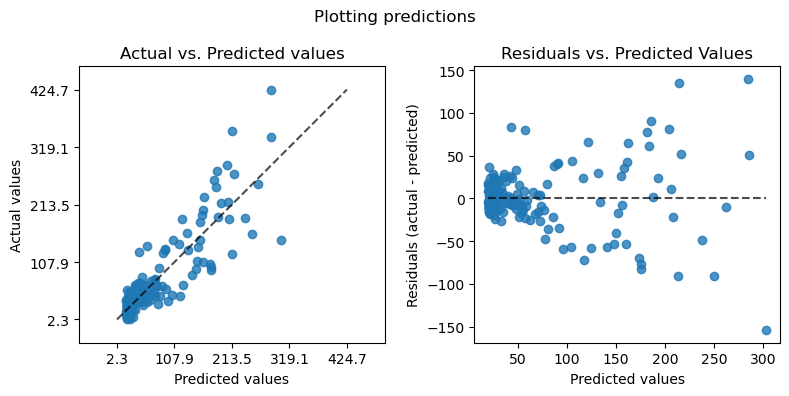

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

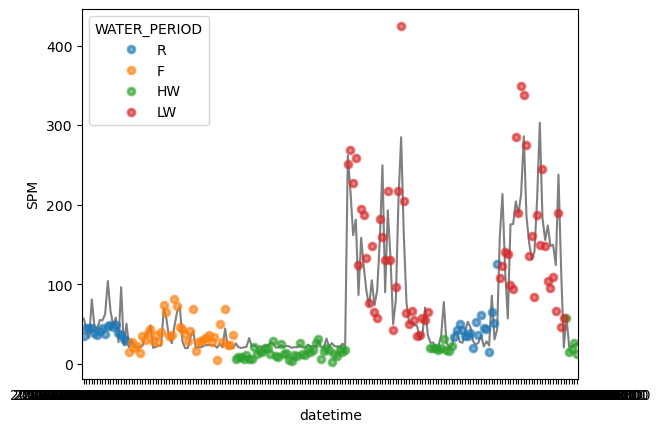

In [17]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Multiple linear regression

In [18]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [19]:
ols_fit = ols.fit(X, y)
y_pred_mlr = ols_fit.predict(X)

In [20]:
print(f"intercept: {ols_fit.intercept_}")
for n in range(len(X.columns)):

    print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

intercept: -12.007375060336429
blue_mean coef: -1356.2182115072562
green_mean coef: 1045.3200324064242
nir_mean coef: 6204.051591240129
red_mean coef: -626.0512685569552


In [21]:
metrics = model_metrics(y,y_pred_mlr)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.7312429382255918, 'mae': 25.662056294174953, 'mse': 1442.4266602697803, 'mape': 0.6272036469220751, 'exp_var': 0.7312429382255918}


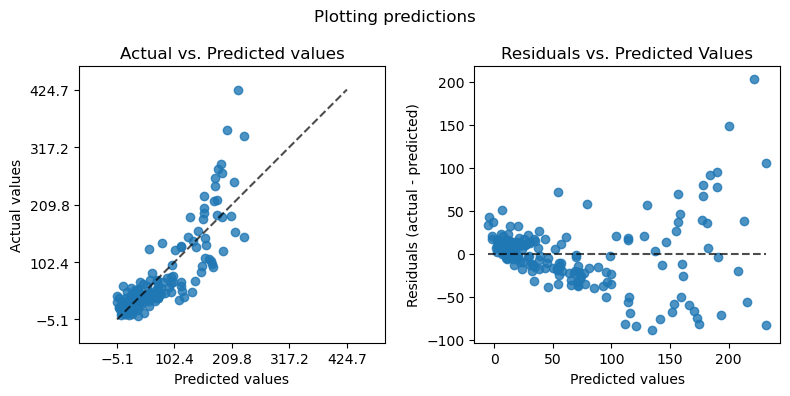

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_mlr,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

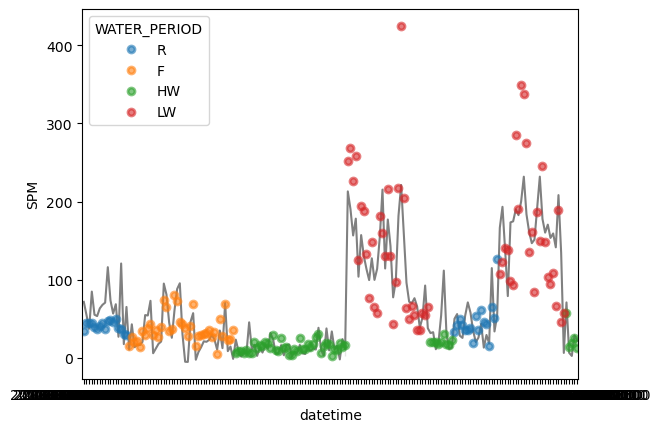

In [23]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_mlr,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')


## Polynomial multiple regression

In [24]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [25]:
model_fit = model_poly.fit(X, y)



In [26]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [  -1125.08018111   -6870.9283391    -1628.96907171    5836.86562904
  -27377.80932747 -524702.41476944 -163201.45473153  495156.28747796
  421579.05968568  180494.68888657 -218479.87695167  213018.90590744
  -75007.3848538  -107644.04230501]
intercept: 21.770360531776532


In [27]:
y_pred_model = model_fit.predict(X)

In [28]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.8067844304170517, 'mae': 19.678273162345402, 'mse': 1036.9933608650351, 'mape': 0.4190075349016725, 'exp_var': 0.8067844304170517}


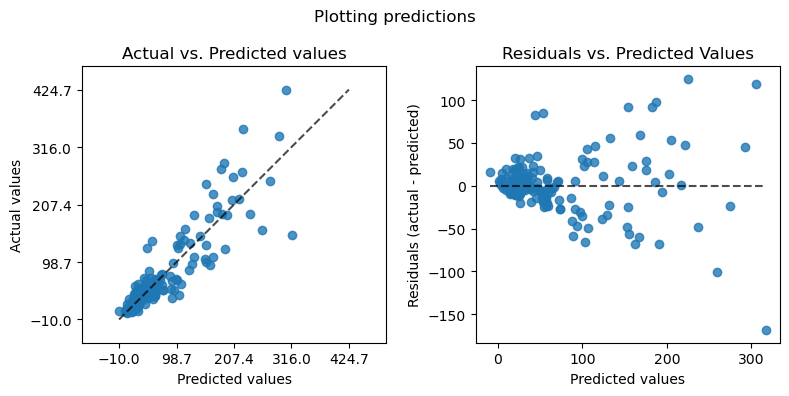

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

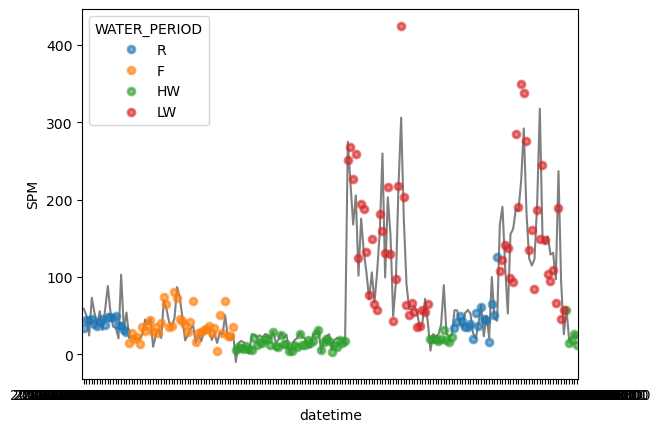

In [30]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Splines (multiple)

In [31]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()
# X = df_subset.drop('SPM',axis = 1).copy()

In [32]:
model_fit = model_splines.fit(X, y)

In [33]:
print(f"coefficients: {model_fit.named_steps['linear'].coef_}")
print(f"intercept: {model_fit.named_steps['linear'].intercept_}")

coefficients: [  41.75027764 -142.17945599 -136.74515003 -134.80457859 -156.43656525
 -284.90224918  813.3177214   -47.7605515   164.50281229  136.32237798
  155.43605416  130.59398741  395.66197804 -934.75665838   73.60678101
 -150.70361781  -89.80247394  -88.31417249   73.55438476  186.80879956
   -5.14970109   42.50618767 -128.39038288  -85.16262432  -84.92479972
  -65.44008327 -265.39717459  586.8088771 ]
intercept: 214.05140772361213


In [34]:
y_pred_model = model_fit.predict(X)

In [35]:
metrics = model_metrics(y,y_pred_model)
print('Metrics:')
print(metrics)

Metrics:
{'r2': 0.8448603610243774, 'mae': 18.587031453391266, 'mse': 832.6387773613299, 'mape': 0.3687771305670884, 'exp_var': 0.8448603610243774}


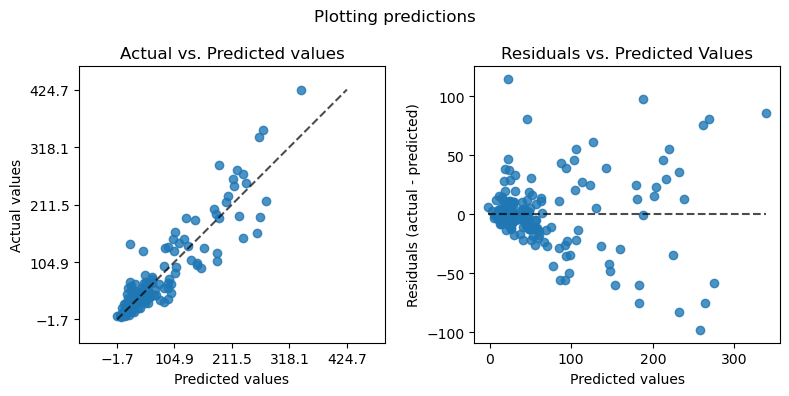

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred_model,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

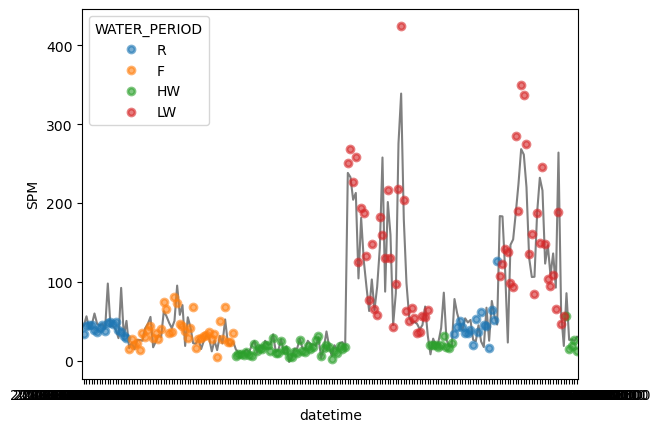

In [37]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred_model,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

## Water Period 

In [38]:
# separate data per water period
water_periods = df_subset.WATER_PERIOD.unique()
df_periods_list = []
for period in water_periods:
    df = df_subset.loc[df_subset['WATER_PERIOD'] == period].copy()
    # print(df.head())
    df_periods_list.append(df)

### Multiple linear regession

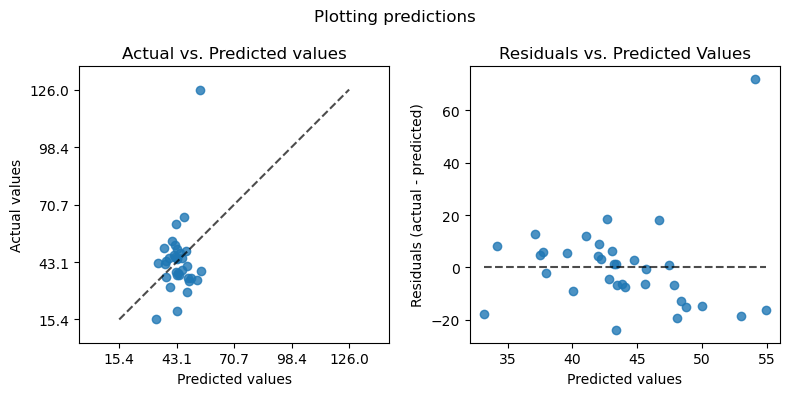

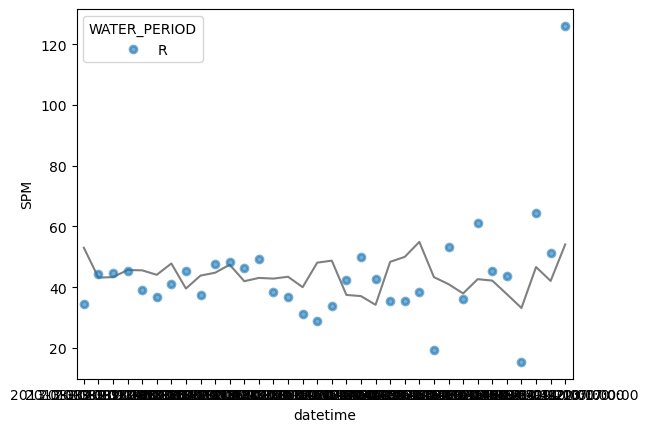

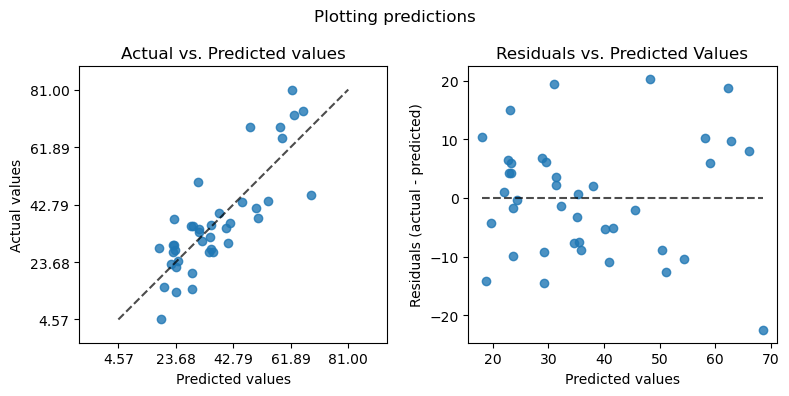

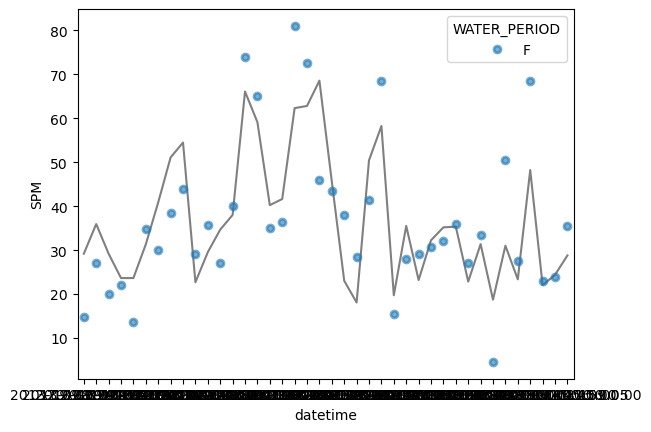

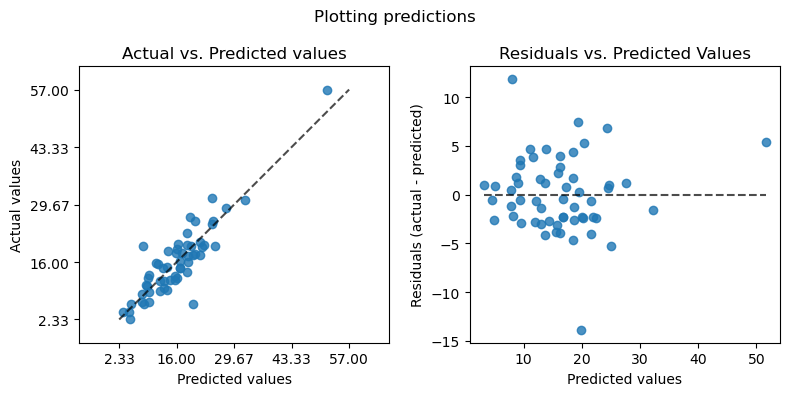

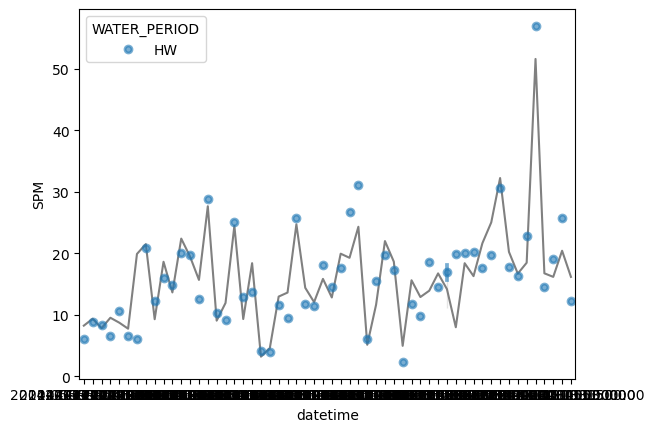

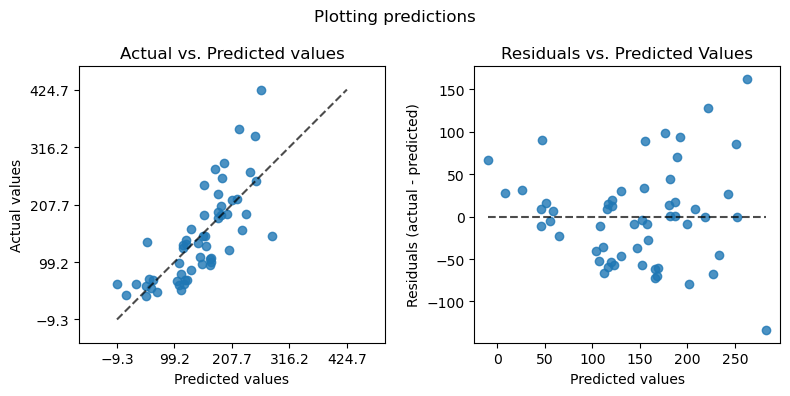

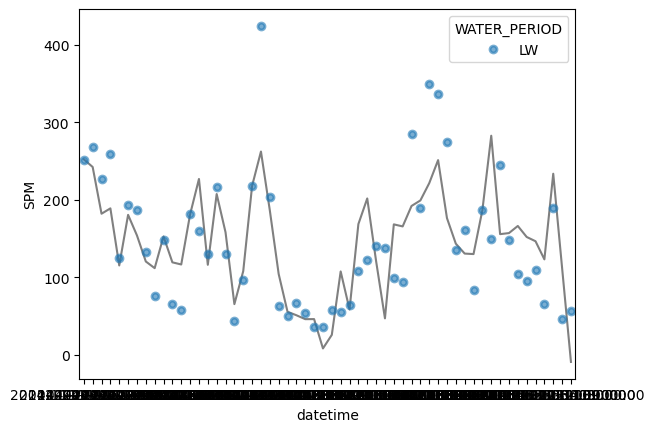

In [47]:
metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()
    
    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = ols.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)
    

    intercept_list.append(ols_fit.intercept_)
    

    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")
    
    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)
    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [48]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")

coefficients: {'R': {'blue_mean': 1004.7918024854201, 'green_mean': -4200.627835363222, 'nir_mean': 223.826700863722, 'red_mean': 3227.8921675823763}, 'F': {'blue_mean': 1138.9343630579326, 'green_mean': -1368.703263595641, 'nir_mean': 1921.1416325804084, 'red_mean': 1107.0645120923837}, 'HW': {'blue_mean': -302.4988602070964, 'green_mean': -1198.4330045549013, 'nir_mean': 1138.786803778078, 'red_mean': 1738.470843860583}, 'LW': {'blue_mean': 6752.084901171003, 'green_mean': -5758.528110670007, 'nir_mean': 8263.007679472814, 'red_mean': 307.5189753059831}}
intercepts: {'R': 32.857331515816526, 'F': 15.834164891180649, 'HW': -1.5936555521810867, 'LW': -10.553798661765626}
metrics: {'R': {'r2': 0.0862373154903796, 'mae': 11.022930260097372, 'mse': 272.6834968760549, 'mape': 0.27606252132064435, 'exp_var': 0.0862373154903796}, 'F': {'r2': 0.6785155552517949, 'mae': 8.031040705770938, 'mse': 96.01582091165956, 'mape': 0.30366272459002863, 'exp_var': 0.6785155552517949}, 'HW': {'r2': 0.8004

### Multiple polynomial regession

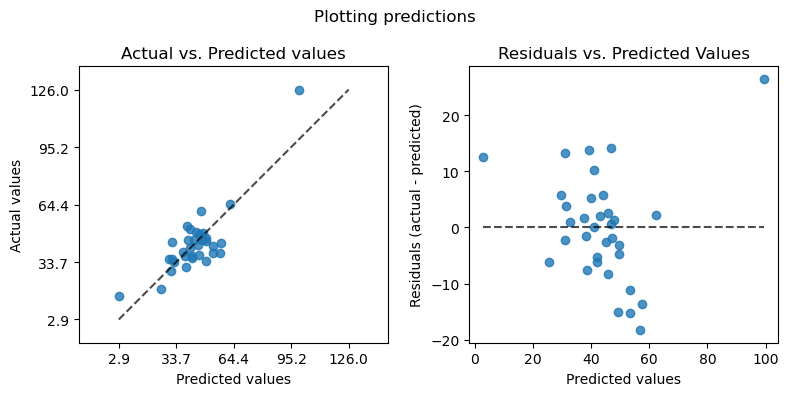

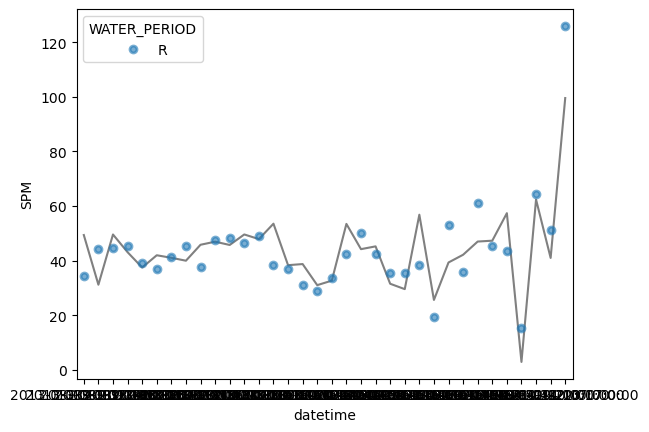

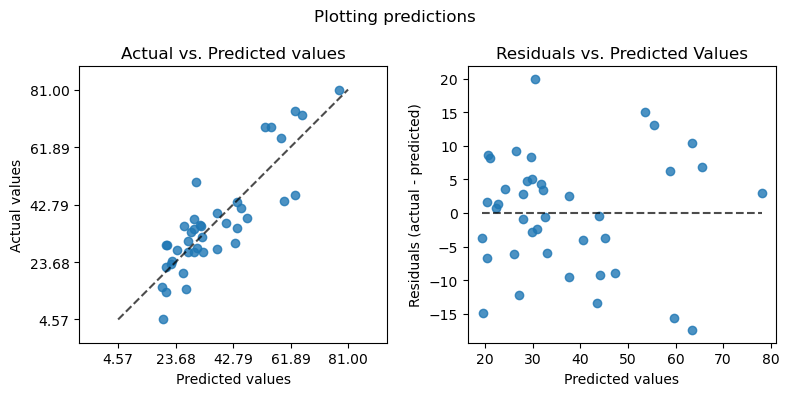

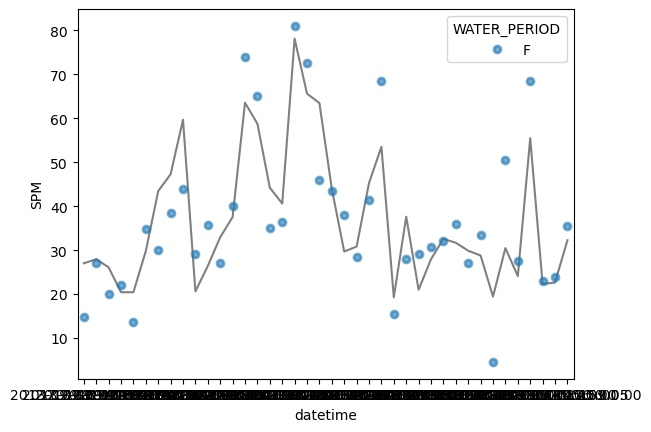

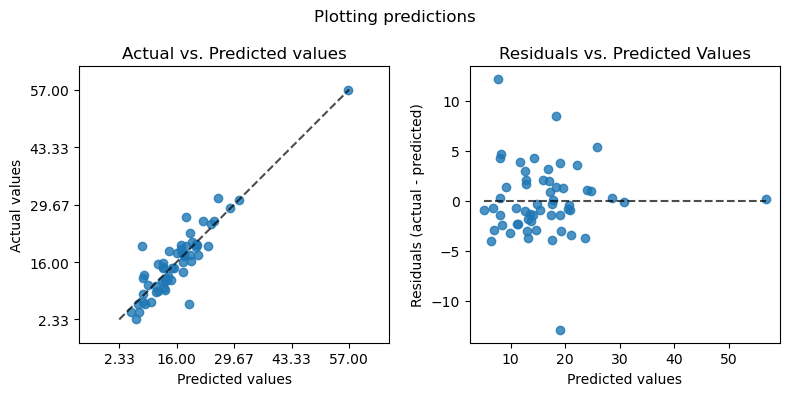

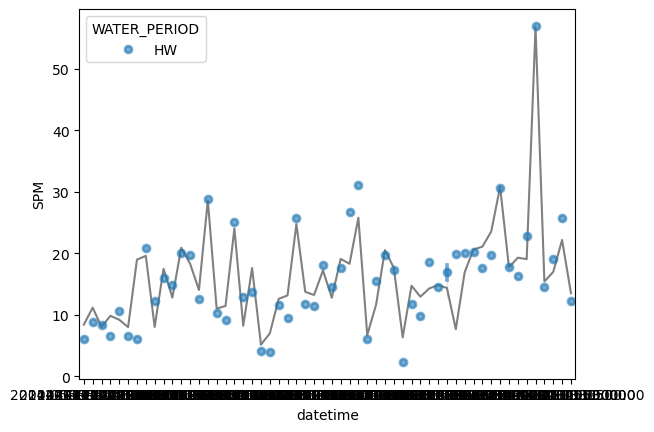

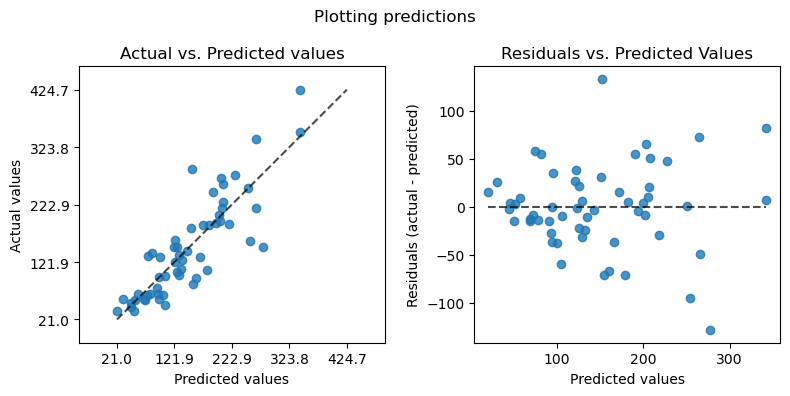

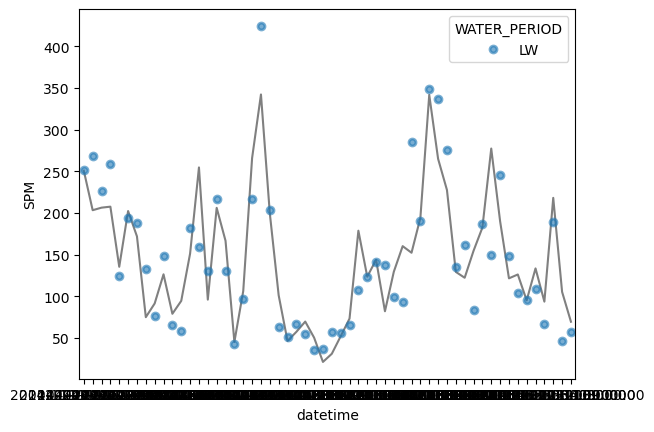

In [44]:
metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()
    
    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = model_poly.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)
    

    intercept_list.append(ols_fit.named_steps['linear'].intercept_)
    

    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")
    
    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)
    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [46]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")

coefficients: {'R': {'blue_mean': 27688.791015432034, 'green_mean': -59787.88956729227, 'nir_mean': -10211.621822648836, 'red_mean': 44688.292434218994}, 'F': {'blue_mean': 8278.437999086205, 'green_mean': -7652.734011525442, 'nir_mean': -1203.7266635530384, 'red_mean': 3286.097657902486}, 'HW': {'blue_mean': -3927.8084232571614, 'green_mean': 6513.886632137865, 'nir_mean': 682.298982872112, 'red_mean': -2447.5224404018263}, 'LW': {'blue_mean': -6051.634047217832, 'green_mean': -43142.91586424539, 'nir_mean': 8120.400737433806, 'red_mean': 2385.9940815565656}}
intercepts: {'R': -54.89661210546643, 'F': 29.976072823417795, 'HW': -0.1688291665341346, 'LW': 415.2680597875832}
metrics: {'R': {'r2': 0.7009330597603001, 'mae': 7.225060418197793, 'mse': 89.24704460693584, 'mape': 0.18056232533607355, 'exp_var': 0.7009330597603001}, 'F': {'r2': 0.7542267518651873, 'mae': 6.939641832651082, 'mse': 73.40361427524651, 'mape': 0.2743701623752788, 'exp_var': 0.7542267518651873}, 'HW': {'r2': 0.8324

### Multiple spline regession

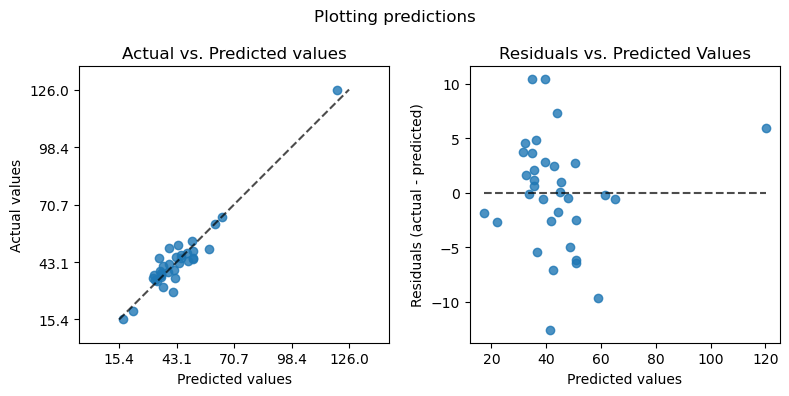

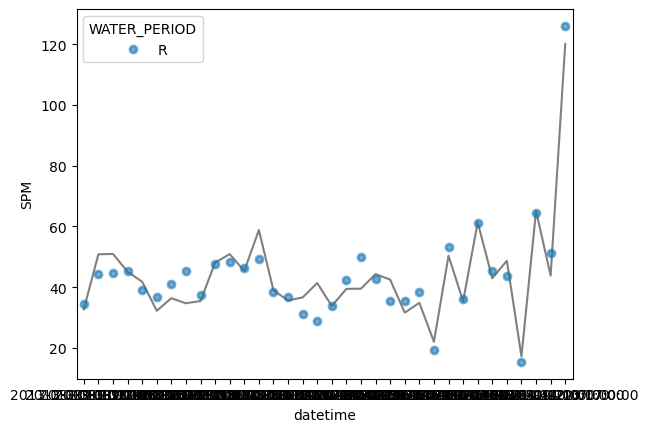

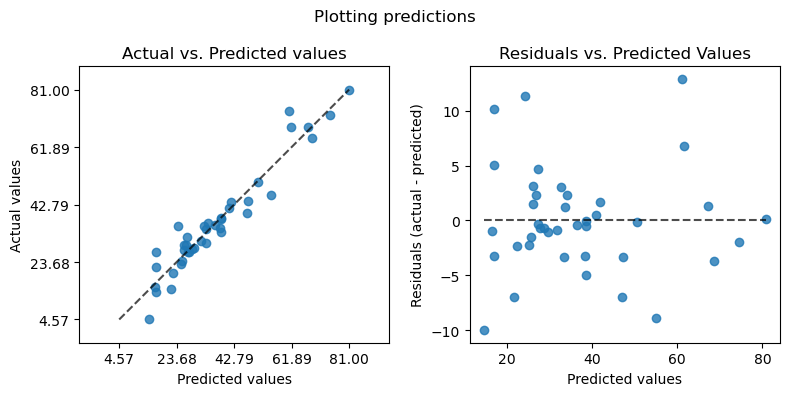

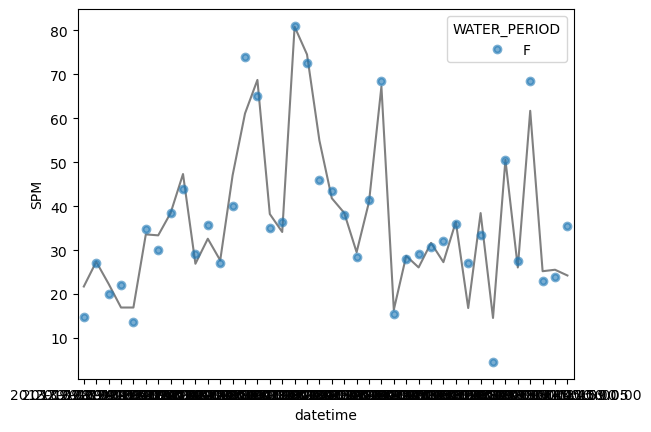

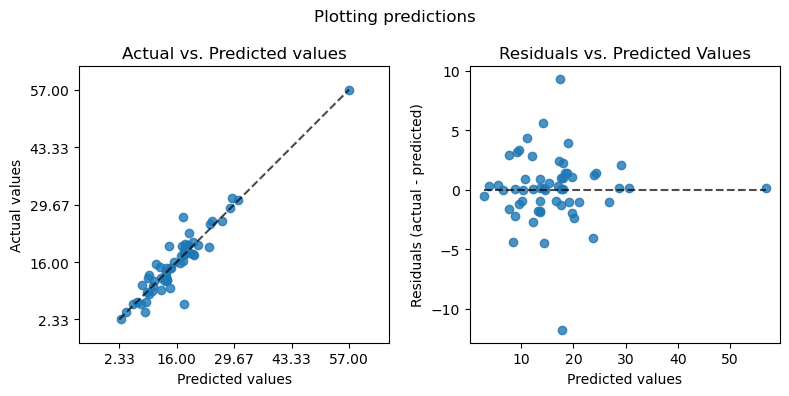

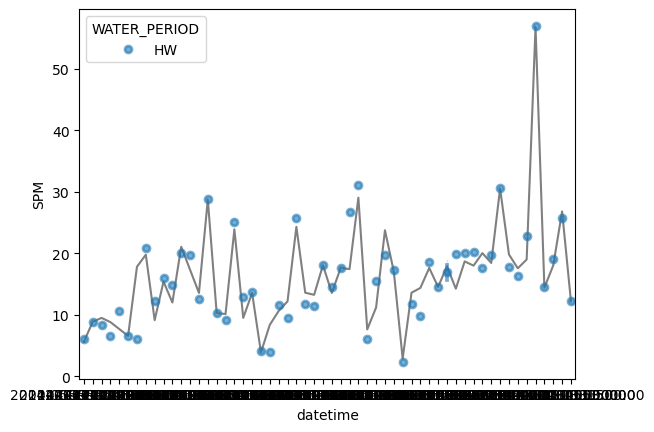

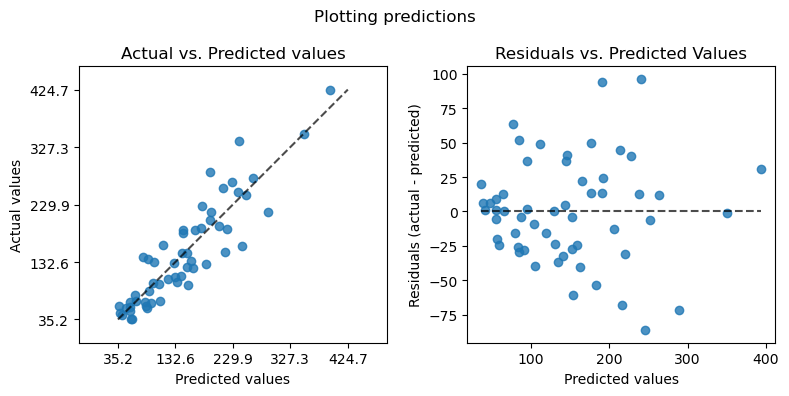

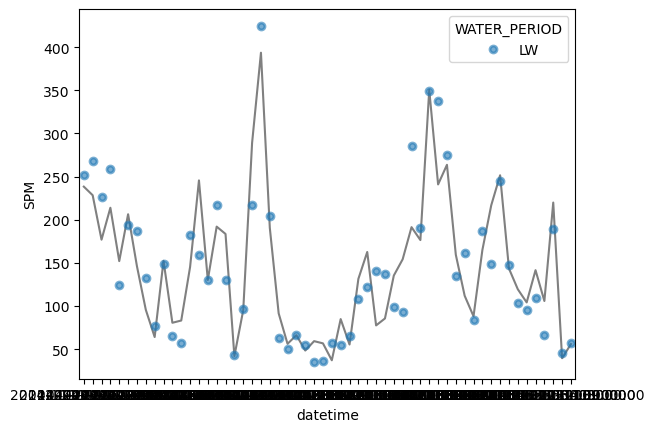

In [49]:
metrics_list=[]
coef_list = []
intercept_list = []

for dataset in df_periods_list:
    # print(dataset['WATER_PERIOD'].iloc[0])
    y = dataset['SPM'].copy()
    
    X = dataset.drop(drop_columns_X_model,axis = 1).copy()
    ols_fit = model_splines.fit(X, y)
    y_pred_mlr = ols_fit.predict(X)
    

    intercept_list.append(ols_fit.named_steps['linear'].intercept_)
    

    # print('equation')
    # print(f"intercept: {ols_fit.intercept_}")
    
    # for n in range(len(X.columns)):

    #     print(f"{X.columns[n]} coef: {ols_fit.coef_[n]}")

    coef_dic = dict(zip(X.columns, ols_fit.named_steps['linear'].coef_))

    coef_list.append(coef_dic)

    metrics = model_metrics(y,y_pred_mlr)
    metrics_list.append(metrics)
    # print(' ')
    # print('Metrics:')
    # print(metrics)
    # print(' ')

    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred_mlr,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting predictions")
    plt.tight_layout()
    plt.show()

    sns.lineplot(data=dataset, x ='datetime',y= y_pred_mlr,color='gray')
    sns.pointplot(data=dataset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [50]:
dictionary_coef = dict(zip(water_periods, coef_list))
print(f"coefficients: {dictionary_coef}")
dictionary_intercep = dict(zip(water_periods, intercept_list))
print(f"intercepts: {dictionary_intercep}")
dictionary_metrics = dict(zip(water_periods, metrics_list))
print(f"metrics: {dictionary_metrics}")

coefficients: {'R': {'blue_mean': 630.5407685775368, 'green_mean': 9.609176173716177, 'nir_mean': 235.5691201567489, 'red_mean': 194.43220613822197}, 'F': {'blue_mean': -218.0531749988943, 'green_mean': 87.81193442577212, 'nir_mean': -7.450500628899147, 'red_mean': 40.904151507532504}, 'HW': {'blue_mean': 104904778721830.0, 'green_mean': 104904778721878.28, 'nir_mean': 104904778721832.98, 'red_mean': 104904778721835.84}, 'LW': {'blue_mean': 1706.166199214174, 'green_mean': -135.16466873141792, 'nir_mean': -371.20950856891494, 'red_mean': -197.91756020834367}}
intercepts: {'R': 989.300061247691, 'F': 5.068907211004593, 'HW': 224133266097231.25, 'LW': 718.4775487891576}
metrics: {'R': {'r2': 0.9137761392684416, 'mae': 3.864169975421845, 'mse': 25.73077699167935, 'mape': 0.09655567754143879, 'exp_var': 0.9137761392684416}, 'F': {'r2': 0.9236524865400835, 'mae': 3.418427718768201, 'mse': 22.802251552666416, 'mape': 0.15286222330506707, 'exp_var': 0.9236524865400835}, 'HW': {'r2': 0.8932901